In [9]:
import pandas as pd
import matplotlib.pyplot as plt

class DatasetHandler:

    def __init__(self, filename):
        """
        Reads the data into a dataframe and does initial processing
        """
        assert isinstance(filename, str)
        assert len(filename) > 0

        self._plot = False # controls whether plots should be displayed. Useful for debugging

        try:
            self._df = pd.read_csv(filename)
        except FileNotFoundError:
            print("The file could not be found!")

    def clean_dataset(self):
        """
        Cleans the dataset i.e removes NaNs, errors, etc... and makes the dataset simpler to use.
        """
        # if we run the following, we see that Legislative District has the most number of NaN values
        self._df.isna().sum().to_frame('NaN')
        # we can fix this as follows:
        self._df['Legislative District'] = self._df['Legislative District'].map(lambda x: str(x).split('.')[0])
        # in a similar way for Vehicle Location
        # forward fill propigates the last observed values to fill the NaN slots
        self._df['Vehicle Location'] = self._df['Vehicle Location'].ffill()
        # Secondly, Legislative District is of dtype object, when it should be float so we can change it

        # We can rename the electric vehicle types for simplicity, i.e Plug-in Hybrid Electric Vehicle (PHEV) to PHEV

    def create_boxplot(self, data={}):
        """
        Creates a boxplot
        """
        fig = plt.figure()
        ax  = fig.add_subplot(111)
        plt.boxplot(data["data"])
        plt.xlabel(data["xlabel"])
        plt.ylabel(data["ylabel"])
        # ax.set_xticklabels(years)
        plt.title(data['title'])
        plt.tight_layout()
        if self._plot: plt.show()

    def create_barplot(self, data={}):
        """
        Creates a barplot
        """
        fig = plt.figure()
        ax  = fig.add_subplot(111)
        plt.bar(data['x'], data['y'])
        plt.xlabel(data["xlabel"])
        plt.ylabel(data["ylabel"])
        plt.xticks(rotation=90)
        plt.title(data['title'])
        plt.tight_layout()
        if self._plot: plt.show()

    def create_piechart(self, data={}):
        """
        Creates a piechart
        """
        fig = plt.figure()
        ax  = fig.add_subplot(111)
        plt.pie(data['x'], labels=data['y'])
        plt.title(data['title'])
        plt.tight_layout()
        if self._plot: plt.show()

    def create_map(self, data={}):
        """_summary_

        :param data: _description_, defaults to {}
        :type data: dict, optional
        """
        pass

In [10]:
from dataset_handler import DatasetHandler

handler = DatasetHandler("Electric_Vehicle_Population_Data.csv")
handler.clean_dataset()
handler._plot = False

years=sorted(handler._df['Model Year'].unique())
yearly=[]
for year in years:
    byyear=handler._df.loc[handler._df['Model Year'] == year].values
    yearly.append([x[10] for x in byyear])
    
boxplot_data = {
    'xlabel': 'Model Year',
    'ylabel': 'Electric Range',
    'title' : 'Electric Range by Model Year',
    'data': yearly
}

# displays the makes and the number of cars in each section
maker_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Makers',
    'x': handler._df['Make'].value_counts().head(10).index.to_list(),
    'y': handler._df['Make'].value_counts().head(10).to_list()
}

# displays the Model and the number of cars in each section
model_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Models',
    'x': handler._df['Model'].value_counts().head(10).index.to_list(),
    'y': handler._df['Model'].value_counts().head(10).to_list()
}

car_type = {
    'title' : 'Vehicle type distribution',
    'y': handler._df['Electric Vehicle Type'].value_counts().head(10).index.to_list(),
    'x': handler._df['Electric Vehicle Type'].value_counts().head(10).to_list()
}

# print(handler._df['Electric Vehicle Type'].value_counts().head(10).to_list())

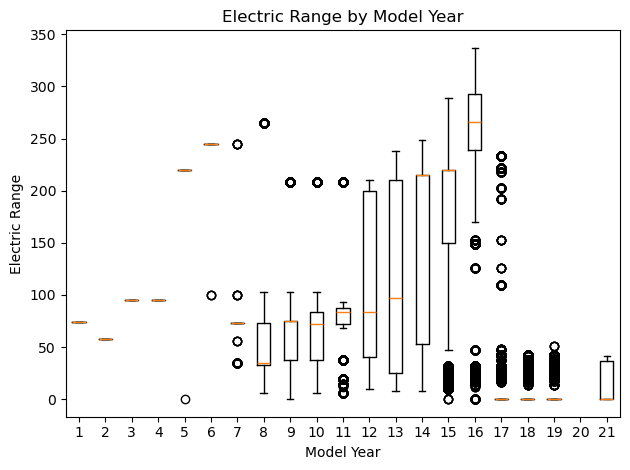

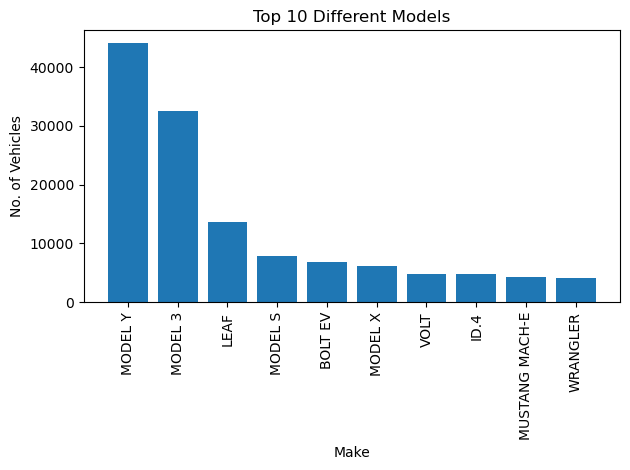

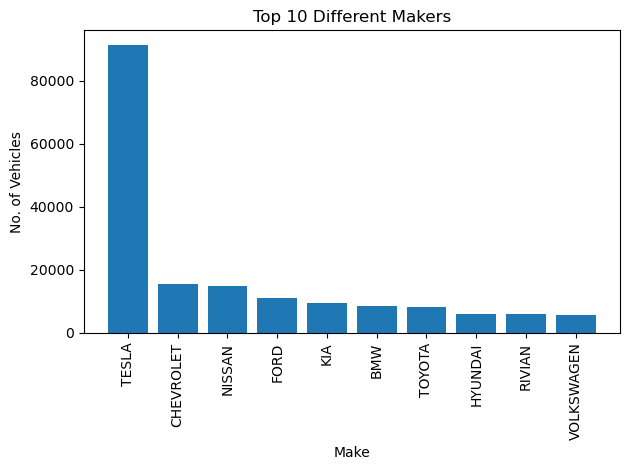

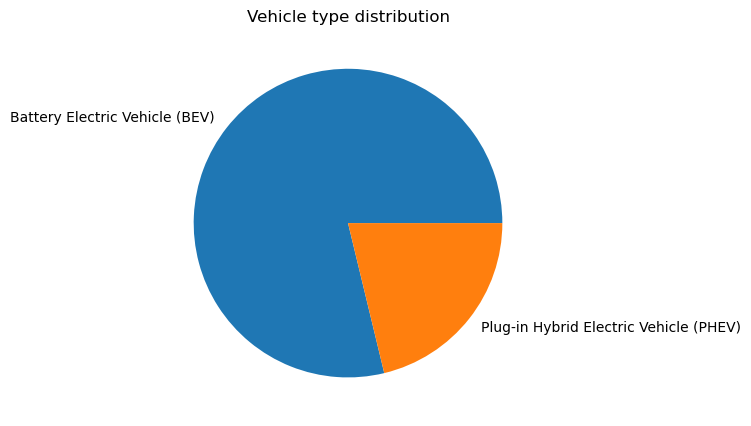

In [11]:
handler._plot = True
handler.create_boxplot(boxplot_data)
handler.create_barplot(model_data)
handler.create_barplot(maker_data)
handler.create_piechart(car_type)
